In [2]:
import gpt as g
import numpy as np
import qlat as q
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.linalg import inv
from scipy.linalg import eigh
from scipy.stats import f as fdist
from abc import ABC, abstractmethod

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

# Two pion scattering in the $I=0$ channel

## Helper functions

In [437]:
def covariance(data, shrinkage=0.1):
    
    nconf,tsize=data.shape
    covmat=np.zeros((tsize,tsize))
    avg = np.average(data,axis=0)
    for n in range(nconf):
        covmat+=np.outer(data[n]-avg,data[n]-avg)
    covmat*=1/nconf
    covmat *= nconf-1

    #shrink toward diagonal
    diag_cov = np.diag(np.diag(covmat))
    covmat_shrunk = (1-shrinkage) * covmat + shrinkage * diag_cov
    
    return avg,covmat_shrunk
#write a model function for the ground state, it should be simply an exponential fit form just like a single pion.
#use this const plus exp or a multi exponential for the excited states

#ground state fit form
def const_fit(t,*p):
    
    return p[0]

def pure_exp(t,*p):
    return p[0]*np.exp(-t*p[1])

def gs_linear(t,*p):
    return -np.log(p[1]) + p[0]*t

#p are the fitting parameters, of which we should have either 2(ground state) or 4(excited states)
def const_plus_exp(t,*p):
    
    #E + Ae^{-t*DeltaE)
    return p[0]+p[1]*np.exp(-t*p[2])
    
#calcualtes the variance of a multi-paramter function, where c is a square matrix with dimensions of the same size as the number of parameters. 
def err_const_plus_exp(t,p,c):
    
    fact = np.exp(-t*p[2])
    errsq  =   c[0][0]
    errsq +=   c[1][1]*(fact)**2
    errsq +=   c[2][2]*((-t)*p[1]*fact)**2
    errsq += 2*c[0][1]*fact
    errsq += 2*c[0][2]*(-t)*p[1]*fact
    errsq += 2*c[1][2]*(-t)*p[1]*fact**2
    
    return np.sqrt(errsq)

In [438]:
def ex_fit(ens_ncf, ens_energy, maxOp, tmin, tmax):
    #ens_energy are the energies here, but in the same shape as the GEVP evals, (ncf, nt, nOp)
    print(ens_energy.shape)
    minOp = 0
    npar = 1
    ncf = ens_ncf
    fitpars_ex=np.zeros((maxOp,ncf,npar))
    fitcov_ex=np.zeros((maxOp,ncf,npar,npar))
    csq=np.zeros((maxOp,ncf))
    guess=([0.5])
    for l in range(0,maxOp):
        avg,cov=covariance(ens_energy[:,tmin:tmax,l],shrinkage=0.2) #shrinkage allows for regularization of the covariance matrix if it isn't positive definite
        dof=tmax-tmin-npar
        t=np.arange(tmin,tmax)
        for jk in range(ncf):
            val = ens_energy[jk,tmin:tmax,l]
            popt,pcov=curve_fit(const_fit,t,val,sigma=cov, 
                            p0=guess, absolute_sigma=True,maxfev=2000)
            
            fitpars_ex[l][jk] = popt
            fitcov_ex[l][jk] = pcov
            theory = const_fit(t, *popt)
            r = avg - theory
            csq[l][jk] = r.T @ inv(cov) @ r
            
        cs=jack(csq[l])
        F = fdist(dof,ncf-dof)
        p_value = 1 - F.cdf(cs[0]/dof/(ncf-1)*(ncf-dof))
        print('n, chi square, dof=',l,cs,dof)
        print('p-value=',p_value)
        print("----------------------------------------")

    return fitpars_ex, fitcov_ex

def ex_fit_ln(ens_ncf,ens_evals, maxOp, tmin, tmax):
    minOp=0
    npar = 1 #each excited state has the energy, amplitude, and deltaE params
    ncf = ens_ncf
    fitpars_ex=np.zeros((maxOp,ncf, npar))
    fitcov_ex=np.zeros((maxOp,ncf,npar,npar))
    csq=np.zeros((maxOp,ncf))
    guess=([0.5])

    for l in range(0,maxOp):
        l = int(l)
        #covariance matrix to calculate timeslice correlations
        avg,cov=covariance(-np.log(ens_evals[:,tmin:tmax,l]),shrinkage=0.2) #shrinkage allows for regularization of the covariance matrix if it isn't positive definite
        dof=tmax-tmin-npar
        t=np.arange(tmin,tmax)

        #fit each jackknife block using the same correlation matrix
        for jk in range(ncf):
            val = -np.log(ens_evals[jk,tmin:tmax,l])
            popt,pcov=curve_fit(const_fit,t,val,sigma=cov, 
                            p0=guess, absolute_sigma=True,maxfev=5000)
            
            fitpars_ex[l][jk] = popt
            fitcov_ex[l][jk] = pcov
            theory = const_fit(t, *popt)
            #r = avg - theory
            r = val - theory
            csq[l][jk] = r.T @ inv(cov) @ r
        cs=jack(csq[l])
        F = fdist(dof,ncf-dof)
        p_value = 1 - F.cdf(cs[0]/dof/(ncf-1)*(ncf-dof))
        print('n, chi square, dof=',l,cs,dof)
        print('p-value=',p_value)
        print("----------------------------------------")

    return fitpars_ex, fitcov_ex

In [439]:
#constructs Ncf jackknife blocks
def jackblocks_expr(data,omit,prt=0):
    #loop over timeslices
    #assuming shape (Ncf,NT)
    jacks = np.zeros(data.shape,dtype=np.complex128)
    nconf=data.shape[0]
    nexp = data.shape[1]
    nt=data.shape[2]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        s=np.zeros(nexp,dtype=np.complex128)
        for i in range(0,nconf):
            if i not in omit:
                s[:] = s[:] + data[i,:,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,:,j] = s[:]-data[i,:,j]
                jacks[n,:,j] *= norm
                n=n+1

    return jacks

#constructs Ncf jackknife blocks, data is a matrix shape, (nOp, nOp, ncf, nt)
def jackblocks_mat(data,omit,prt=0):
    #loop over timeslices
    #assuming shape (Ncf,NT)
    jacks = np.zeros(data.shape,dtype=np.complex128)
    nOp = data.shape[0]
    nconf=data.shape[2]
    nt=data.shape[3]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        s=np.zeros((nOp, nOp),dtype=np.complex128)
        for i in range(0,nconf):
            if i not in omit:
                s[:,:] = s[:,:] + data[:,:,i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[:,:,n,j] = s[:,:]-data[:,:,i,j]
                jacks[:,:,n,j] *= norm
                n=n+1

    return jacks

def jackblocks_pos(data,omit,prt=0):
    #loop over timeslices
    #assuming shape (Ncf,NS,NS,NS)
    jacks = np.zeros(data.shape,dtype=np.complex128)
    nconf=data.shape[0]
    ns=data.shape[-1]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    #for j in range(0,ns):
        #
        # sum over configs
        #
    s=np.zeros((ns,ns,ns),dtype=np.complex128)
    for i in range(0,nconf):
        if i not in omit:
            s[:,:,:] = s[:,:,:] + data[i,:,:,:]
    #
    # contruct jacks for time slice j
    #
    n=0
    for i in range(0,nconf):
        if i not in omit:
            jacks[n,:,:,:] = s[:,:,:]-data[i,:,:,:]
            jacks[n,:,:,:] *= norm
            n=n+1

    return jacks

def jackblocks(data,omit,prt=0):
    #loop over timeslices
    #assuming shape (Ncf,NT)
    jacks = np.zeros(data.shape,dtype=np.complex128)
    nconf=data.shape[0]
    nt=data.shape[-1]
    norm=1.0/(nconf-1-len(omit))
    if(prt):print('omitting '+str(len(omit))+' of '+str(nconf)+' configs')
    for j in range(0,nt):
        #
        # sum over configs
        #
        s=0.0
        for i in range(0,nconf):
            if i not in omit:
                s = s + data[i,j]
        #
        # contruct jacks for time slice j
        #
        n=0
        for i in range(0,nconf):
            if i not in omit:
                jacks[n,j] = s-data[i,j]
                jacks[n,j] *= norm
                n=n+1

    return jacks

def jack(vec):
    n=vec.shape[0]
    avg=0.0
    # compute average
    for i in range(0,n):
        avg+=vec[i]
    avg = avg/n
    # compute error
    err=0.0
    for i in range(0,n):
        err+=(vec[i]-avg)*(vec[i]-avg)
    err *= (n-1)/n
    err = np.sqrt(err)
    #print(f'{n} blocks, avg+-err= {avg:.4e} +- {err:.4e}')
    return avg, err

In [440]:
def GEVP(ens_params,minOp,maxOp,tmin,tmax):
    ncf = ens_params.ncf
    nt = ens_params.nt
    ens_params.e = np.zeros((ncf, nt, maxOp-minOp))
    ens_params.vec=np.zeros((ncf, nt, maxOp-minOp, maxOp-minOp))
    
    for cf in range(ncf):
        for t in range(tmin,tmax):
            a = ens_params.jks[minOp:maxOp, minOp:maxOp, cf, t] #C(t) for some jackknife block
            b = ens_params.jks[minOp:maxOp, minOp:maxOp, cf, t-1] #C(t_0) for some jackknife block
            #np.linalg.cholesky(b) error here if b is not positive definite
            a = 0.5*(a+np.conjugate(np.transpose(a))) #ensure hermiticity
            b = 0.5*(b+np.conjugate(np.transpose(b)))

            ev, evec = eigh(a,b,type=1)

            #sort the eigenvalues into descending order
            ev_desc = ev[::-1]
            ens_params.e[cf,t] = ev_desc
            #sort the columns of the eigenvectors to match
            vec_desc = evec[:,::-1]
            ens_params.vec[cf,t] = vec_desc
            #ens_params.e[cf,t],ens_params.vec[cf,t]=eigh(a,b,type=1) # Type 1 => a @ v = w @ b @ v

In [22]:
#this is the base correlator class, defining the basic properties of each correlator we will use, regardless of operator
class CorrelatorBase(ABC):
    def __init__(self,op1, op2):
        return 0

#Given some set of operators used in the calculation of correlation functions, this object sets up the correlator matrix structure
#that is associated with that basis of operators.
class OperatorBasis:
    #operators is a list of strings, op = ['pipi_000', 'sigma', 'pipi_001', 'pipi_011', 'pipi_111'] for the I=0 case
    def __init__(self, operators):
        self.operators = operators
        


#main callable object, here we define our operators, 
class PionScatteringCorrelator:
    #job tag labels the ensemble, op_list is a list of strings of the names of the operators in the operator basis
    #and run_info can be a list of other parameters such as Delta, tsep_max, nt, or anything else. 
    def __init__(self, job_tag, op_list, vac_sub=True, params=None):
        self.job_tag = job_tag
        self.Delta = params[0]
        self.d_sqr = params[1]
        self.operator_basis = OperatorBasis(op_list) #vevs happen in here too.
        self.needs_vacsub = vac_sub

    #method to load the data given a list of paths
    def load_data(self, path_list):
        return 0


In [386]:
class Ensemble_jks():
    #C2pt_jks is of shape (nOp, nOp, ncf, tsep_max)
    #Cvev_jks is of shape (nOp, ncf, nt)
    def __init__(self,C2pt_jks):
        self.nOp = C2pt_jks.shape[0] #input jks data is of shape (nOp, nOp, ncf, nt)
        self.ncf = C2pt_jks.shape[2]
        self.nt = C2pt_jks.shape[3]
        self.C2pt_jks = C2pt_jks 
        self.jks = C2pt_jks
        
        self.vec = 0
        self.e = 0
        pass

## $I = 0$ $5 \times 5$ GEVP

### single config verification

In [ ]:
class LatData_parser:
    def __init__(self, lattice_data):
        self.lattice_data = lattice_data
        self.data_array = lattice_data.to_numpy()
        self.info_list = lattice_data.info()[0]
        self.nexp = info_list[1]
        self.expr_list = info_list[2]

    def parse_expr_names(self):
        expr_map = {}

        for i, expr_names in enumerate(self.expr_list):
            
        
        

In [52]:
import re
s = '< wf_snk(2) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT1)  exprs[14]'
angle = re.compile(r'<(.*)>')
diagram_type = re.compile(r'\((ADT[\d_]+)\)')
index = re.compile(r'exprs\[(\d+)\]')
match = angle.search(s)
print(match.group(1))

 wf_snk(2) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) 


In [29]:
ld_pp.info()[0]

['expr_name',
 82,
 ['< 1 >  exprs[0]',
  '< sigma^dag(0) * sigma(-tsep) >  exprs[1]',
  '< wf_src(0) * sigma^dag(0) * pipi_i00(-tsep) > (ADT1_pps)  exprs[2]',
  '< wf_src(0) * sigma^dag(0) * pipi_i00(-tsep) > (ADT2_pps)  exprs[3]',
  '< wf_src(0) * sigma^dag(0) * pipi_i00(-tsep) > (ADT1_spp)  exprs[4]',
  '< wf_src(0) * sigma^dag(0) * pipi_i00(-tsep) > (ADT2_spp)  exprs[5]',
  '< wf_snk(0) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT1)  exprs[6]',
  '< wf_snk(0) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT2)  exprs[7]',
  '< wf_snk(0) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT3)  exprs[8]',
  '< wf_snk(0) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT4)  exprs[9]',
  '< wf_snk(1) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT1)  exprs[10]',
  '< wf_snk(1) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT2)  exprs[11]',
  '< wf_snk(1) * wf_src(0) * pipi_i00^dag(0) * pipi_i00(-tsep) > (ADT3)  exprs[12]',
  '< wf_snk(1) * wf_src(0) * p

In [247]:
dst_3 = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-type/traj-1102/pipi_corr_psnk_psrc.lat"
dst_vev = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-p/traj-1302/pipi_vev.lat"
dst_meson = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-p-sigma/traj-1142/meson_corr_psnk_psrc_psel.lat"
dst_pp = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-p/traj-1172/pipi_corr_psnk_psrc.lat"
dst_avg = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pipi-pos-avg/traj-1112/pipi_vev_pos_avg.lat"


ld_meson = q.load_lat_data(dst_meson)
ld_vev = q.load_lat_data(dst_vev)
ld_pp = q.load_lat_data(dst_pp)
ld_avg = q.load_lat_data(dst_avg)

q.display_info(ld_avg.info())

[['expr_name', 3, ['< 1 >  exprs[0]', '< pipi_i0(-tsep) >  exprs[1]', '< pipi_i0^dag(0) >  exprs[2]']], ['x_rel', 25, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']], ['y_rel', 25, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']], ['z_rel', 25, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']]]

In [248]:
total_volume = 48*48*48*96
arr_meson = ld_meson.to_numpy()
arr_vev = ld_vev.to_numpy()
#arr_all = ld_all.to_numpy()
arr_pp = ld_pp.to_numpy()
arr_avg = ld_avg.to_numpy()
t = np.linspace(1,95,95)
t_sep = np.linspace(1,23,22)

In [264]:
arr_avg[1,:,1,1]

array([    0.          +0.j        ,     0.          +0.j        ,
           0.          +0.j        ,     0.          +0.j        ,
           0.          +0.j        ,     0.          +0.j        ,
           0.          +0.j        ,     0.          +0.j        ,
       -2839.71125288 +14.50998741j,  -987.3789918   -2.01717556j,
           0.          +0.j        ,     0.          +0.j        ,
           0.          +0.j        ,     0.          +0.j        ,
           0.          +0.j        , -1185.33884634  +4.054355j  ,
           0.          +0.j        , -2478.15595884 -15.67441096j,
       -3177.47536638-379.60878906j,     0.          +0.j        ,
           0.          +0.j        ,     0.          +0.j        ,
           0.          +0.j        , -1870.35116123 +14.52341917j,
           0.          +0.j        ])

In [250]:
counter = arr_avg[0,:,:,:]

In [251]:
mask = counter != 0
avg = np.zeros_like(counter)
avg[mask] = arr_avg[1,mask]/counter[mask]

In [269]:
z_avg = np.sum(np.sum(avg[:,:,:],axis=1),axis=0)

In [578]:
pipi_count = arr_pp[0,:,0] #two factors of volume normalization
vev_count = arr_vev[0,:] # one factor of volume normalization

In [85]:
np.sum(arr_avg[1,:]/total_volume)

np.complex128(-1251.282532656148+0.8696226200679085j)

(-0.0005, 0.0)

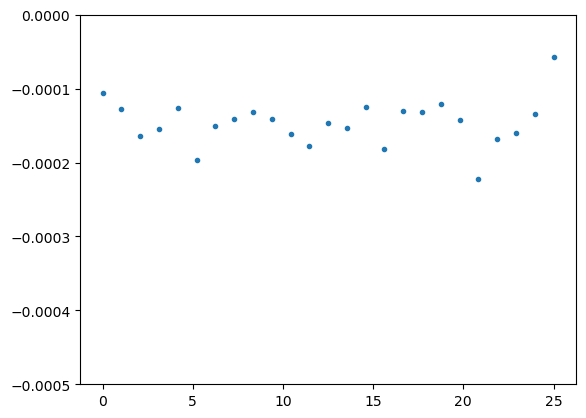

In [270]:
tsep = np.linspace(0,25,25)
fig, ax = plt.subplots()
ax.plot(tsep, z_avg, marker='.', ls='')
#ax.plot(tsep, S, marker='.', ls='')
ax.set_ylim(-0.0005, 0)


In [139]:
t_size = 96
t_sep_size = 96
S = np.zeros(96, dtype=np.complex128)
for tsep in range(0,96):
    s = 0.0
    for tsrc in range(t_size):
        t_1 = (tsep + tsrc) % t_size
        s += (arr_vev[3,t_1])*(arr_vev[4,tsrc])

    S[tsep] = s

In [140]:
(S[:24])/(total_volume**2)

array([0.00071529+6.59722608e-07j, 0.00057976+4.48269613e-08j,
       0.00060015+2.21080090e-07j, 0.00059598+3.35831988e-07j,
       0.0005688 +6.54340387e-08j, 0.00063452-2.18056779e-08j,
       0.00057954+2.30828983e-08j, 0.00059975+1.35830649e-07j,
       0.00058998+2.92717122e-08j, 0.00058751+2.62695684e-07j,
       0.00058076-2.54848908e-07j, 0.00056194+3.34973088e-07j,
       0.00057565+4.70049168e-08j, 0.00057461+1.24914421e-07j,
       0.00060478+4.56365565e-07j, 0.00058527+1.68274542e-07j,
       0.00057024+1.60214179e-07j, 0.00056529+5.42104468e-07j,
       0.00057488+9.34262228e-08j, 0.0005815 +4.45562563e-07j,
       0.00057162+1.09470899e-07j, 0.00058198+2.11109924e-07j,
       0.00055356-2.25832837e-07j, 0.00057972-2.93079823e-08j])

In [114]:
np.sum(arr_vev[1,:])*np.sum(arr_vev[1,:])

np.complex128(0.0572325727993707-5.0277376751738736e-06j)

In [324]:
np.sum(arr_vev[2,:]/0.00019)

np.complex128(-0.233614206810421+7.611048742241748e-06j)

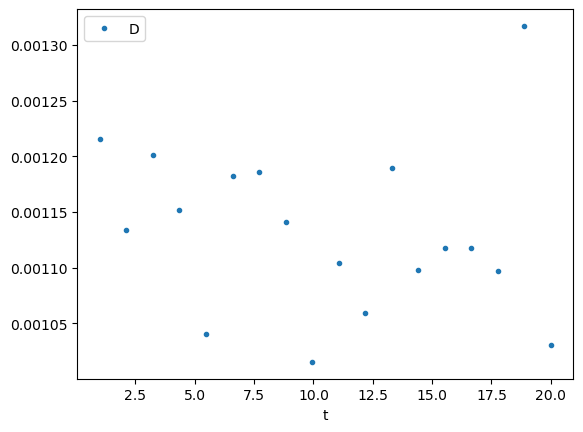

In [567]:
t = np.linspace(1,96,95)
#t_sep = np.linspace(1,16,15)
t_sep = np.linspace(1,20,18)
fig, ax = plt.subplots()
#ax.plot(t_sep, pipi_sub[0,1:], marker='.', ls='',label="(0,0,0)")
#ax.plot(t_sep, pipi_sub[1,1:], marker='.', ls='',label="(0,0,1)")
#ax.plot(t_sep, pipi_sub[2,1:], marker='.', ls='',label="(0,1,1)")
#ax.plot(t_sep, pipi_sub[3,1:], marker='.', ls='',label="(1,1,1)")

ax.plot(t_sep, arr_pp[16,1:],marker='.',ls='',label="D")
#ax.plot(t_sep, arr_pp[2,1:],marker='.',ls='',label="C")
#ax.plot(t_sep, arr_pp[3,1:],marker='.',ls='', label="R")
#ax.plot(t_sep, arr_pp[4,1:],marker='.',ls='', label="V")

#ax.plot(t_sep, arr_ps[1,1:,0],marker='.',ls='')

#ax.plot(t, np.sum(arr_vev_meson1[1,1:,:],axis=1),marker='.', ls='',label=r"$\langle \sigma (t) \rangle$")
#ax.plot(t, np.sum(arr_vev_meson1[2,1:,:],axis=1),marker='.', ls='',label=r"$\langle \sigma^{\dagger}(0) \rangle$")

#ax.set_yscale("log")
#ax.set_ylim(10, 20)
#ax.set_title(r"$\langle O_{\pi\pi,i}(t) \ O_{\pi\pi,i}^{\dagger}(0) \rangle - \frac{1}{L_t}\sum_{t_s=0}^{L_t-1}\langle O_{\pi\pi,i}(t+t_s\rangle\langle O_{\pi\pi,i}^{\dagger}(t_s) \rangle$")
ax.set_xlabel("t")
ax.legend();

### sigma analysis and subtraction

In [892]:
ld = q.load_lat_data(f"/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-sigma/traj-{1112}/meson_corr_psnk_psrc_psel.lat")

In [70]:
#here we load in the sigma correlator data and all vev data

dst_list_1 = []
meson_data = []
vev_data = []

for traj in range(1112,1293,10):
    #print(traj)
    dst = f"/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-sigma/traj-{traj}/meson_corr_psnk_psrc_psel.lat"
    dstvev = f"/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-vev/traj-{traj}/pipi_vev.lat"
    meson_data.append(q.load_lat_data(dst).to_numpy())
    vev_data.append(q.load_lat_data(dstvev).to_numpy())

for traj in range(1312,1483,10):
    dst = f"/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-sigma/traj-{traj}/meson_corr_psnk_psrc_psel.lat"
    dstvev = f"/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-vev/traj-{traj}/pipi_vev.lat"
    meson_data.append(q.load_lat_data(dst).to_numpy())
    vev_data.append(q.load_lat_data(dstvev).to_numpy())

ncf_meson = len(meson_data)
meson_arr = np.array(meson_data)
vev_arr = np.array(vev_data)

In [77]:
meson_arr_jk = jackblocks_expr(meson_arr, omit=[])
meson_arr_jk.shape

(37, 4, 96)

In [78]:
#picking out just the sigma vev data
ncf = meson_arr.shape[0]
nt = meson_arr.shape[-1]
sigma_vev_arr = np.zeros((ncf, 2, nt))
sigma_vev_arr = vev_arr[:,1:3,:]

sigma_vev_jk = jackblocks_expr(sigma_vev_arr,omit=[])
sigma_vev_jk.shape

(37, 2, 96)

In [79]:
#constructing the total correlator as a sum of the two types
ncf = meson_arr.shape[0]
nt = meson_arr.shape[-1]
meson_total = np.zeros((ncf, nt),dtype=np.complex128)
for cf in range(ncf):
    meson_total[cf,:] = (meson_arr[cf,1,:] + meson_arr[cf,2,:])

meson_total_jk = jackblocks(meson_total, omit=[])

In [80]:
meson_avg, meson_err = jack(meson_arr_jk.real)
meson_total_avg, meson_total_err = jack(meson_total_jk.real)

In [84]:
meson_sub = vac_sub(meson_total_jk, sigma_vev_arr[:,0,:], sigma_vev_arr[:,1,:], Delta=0)

(0.051627580032970966+0.00012713917202368492j)
Subtraction term standard deviation: 0.0009202004452175276


In [22]:
meson_sub_avg, meson_sub_err = jack(meson_sub.real)

(0.0, 0.005)

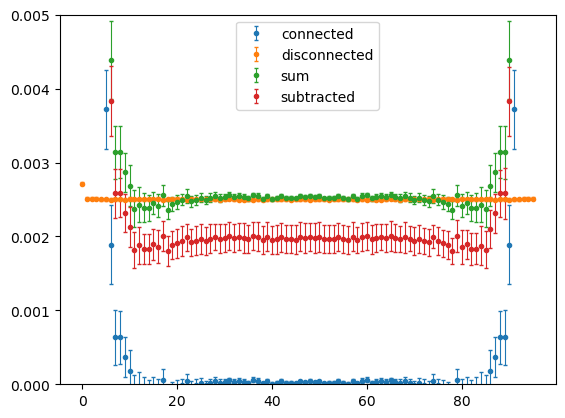

In [23]:
t = np.linspace(0,95,96)
fig, ax = plt.subplots()
ax.errorbar(t, meson_avg[1,:], yerr=meson_err[1,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label="connected")
ax.errorbar(t, meson_avg[2,:], yerr=meson_err[2,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label="disconnected")
#ax.errorbar(t, meson_avg[3,:], yerr=meson_err[3,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label="total")
ax.errorbar(t, meson_total_avg, yerr=meson_total_err, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="sum")
ax.errorbar(t, meson_sub_avg, yerr=meson_sub_err, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="subtracted")
ax.legend();
ax.set_ylim(0,0.005)

In [223]:
dst_meson = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-sigma/"
dst_list_1 = []
meson_data = []

for traj in range(1102,1493,10):
    dst = f"/home/jhildebrand28/ktopipi/results/48I/auto-contract-sigma/traj-{traj}/meson_corr.lat"
    meson_data.append(q.load_lat_data(dst).to_numpy())

ncf_meson = len(meson_data)
meson_arr = np.array(meson_data)

In [271]:
meson_arr.shape

(40, 3, 96)

### pipi analysis and subtraction

In [303]:
#we are looking to subtract 
# C(t) = <O_i * O_j^{dag}> - 1/Lt \sum_{t_src=0}^{L_t-1} <O_i(t+t_src)><O_j(t_src)>
#where in the vev values, the operators with a secondary source are defined with the secondary pioint behind it
#so we need to shift the "sink" operators by 5 timeslices for a Delta of 5. 
#inputs are the 2pt function data and vev data for a given expression. The result should be some C(t), where we have some
#remaining time dependence, based on t_sep. 
def vac_sub(C2pt_jk, Cvev1_jk, Cvev2_jk,Delta):
    Csub_jk = np.zeros_like(C2pt_jk)
    nblks = C2pt_jk.shape[0]
    t_size = Cvev1_jk.shape[-1]
    tsep_max = C2pt_jk.shape[1]
    for jk in range(nblks):
        S = np.zeros(tsep_max,dtype=np.complex128)
        for tsep in range(tsep_max):
            s = 0.0
            for tsrc in range(t_size):
                t_1 = (tsep + tsrc + Delta) % t_size
                s += Cvev1_jk[jk, t_1] * Cvev2_jk[jk,tsrc]

            S[tsep] = (s*96)
            #print(S[tsep])

            Csub_jk[jk,tsep] = C2pt_jk[jk,tsep] - s*96 #(s*48)

    #subtraction term should be very constant
    sub_std = np.std(S[:])
    print(S[0])
    print(f"Subtraction term standard deviation: {sub_std}")
    #assert sub_std < 1e-6, "Subtraction term not constant, standard deviation greater than 1e-6"
            
    return Csub_jk

In [304]:
#specific for a (ncf, nexp, nt) shape, only pipi terms
def pipi_corr_sum(type_data, ntype, nOp):
    ncf = type_data.shape[0]
    nexp = type_data.shape[1]
    nt = type_data.shape[2]
    C_sum = np.zeros((nOp, nOp, ncf, nt),dtype=np.complex128)

    for i in range(nOp):
        for j in range(nOp):
            C_d = np.zeros((ncf, nt),dtype=np.complex128)
            for d in range(ntype):
                C_d[:,:] += type_data[:,(i*4 + j)*4 + 4 + 1 + d ,:]

            C_sum[i,j,:,:] = C_d[:,:]

    return C_sum

def corr_sum_ind(type_data, ntype_pi_sig, ntype_pipi, nOp):
    total_volume = (48*48*48*96) #lattice size
    ncf = type_data.shape[0]
    nexp = type_data.shape[1]
    nexp_pipi = 16
    nexp_pi_sig = 8
    nt = type_data.shape[2]
    C_sum = np.zeros((nOp, nOp, ncf, nt),dtype=np.complex128)

    #for cf in range(ncf):

    k = 0
    l = 0
    for i in range(nOp-1):
        if i >= 1:
            k = i + 1
        else:
            k = i
        
        C_c1 = np.zeros((ncf,nt),dtype=np.complex128) #holds summed correlator for cross terms
        C_c2 = np.zeros((ncf,nt),dtype=np.complex128) #holds summed correlator for cross terms

        #iterate over the two expressions for each cross term, sum them into the intermediate array, and then place them in the 5x5 correlator matrix. 
        for d in range(ntype_pi_sig):
            C_c1[:,:] += type_data[:,i*4*5 + 1 + d + 1,:]
        for d in range(ntype_pi_sig):
            C_c2[:,:] += type_data[:, i*4*5 + 3 + d + 1,:]
                
        #C_sum[k,1,:,:] = (C_c1[:,:]/type_data[:,0,:])*total_volume
        #C_sum[1,k,:,:] = (C_c2[:,:]/type_data[:,0,:])*total_volume

        C_sum[k,1,:,:] = (C_c1[:,:]/(total_volume**2))
        C_sum[1,k,:,:] = (C_c2[:,:]/(total_volume**2))

        for j in range(nOp-1):
            if j >= 1:
                l = j + 1
            else: 
                l = j

            C_d = np.zeros((ncf, nt),dtype=np.complex128)
            for d in range(ntype_pipi):
                C_d[:,:] += type_data[:,(i*4 + j)*4 + 4*(i+1) + 1 + d + 1 ,:]

            print(f"k: {k}, l: {l}")

            #C_sum[k,l,:,:] = (C_d[:,:]/type_data[:,0,:])*total_volume
            C_sum[k,l,:,:] = (C_d[:,:]/(total_volume**2))

    return C_sum

In [306]:
#dst_corr = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-c"
#dst_vev = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-c/"

dst_corr_p = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-p"
dst_vev_p = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-I0D5-p"

#dst_list_corr = []
dst_list_corr_p = []
#dst_list_vev = []
dst_list_vev_p = []

#corr_data = []
corr_data_p = []
#vev_data = []
vev_data_p = []
tsep_max = 20

for traj in range(1102, 1492, 10):
    #print(traj)
    #dst_c = dst_corr + f"/traj-{traj}/pipi_corr_psnk_psrc.lat"
    dst_p = dst_corr_p + f"/traj-{traj}/pipi_corr_psnk_psrc.lat"
    #dst_v = dst_vev + f"/traj-{traj}/pipi_vev.lat"
    dst_vp = dst_vev_p + f"/traj-{traj}/pipi_vev.lat"

    #corr_data.append(q.load_lat_data(dst_c).to_numpy())
    corr_data_p.append(q.load_lat_data(dst_p).to_numpy())
    #vev_data.append(q.load_lat_data(dst_v).to_numpy())
    vev_data_p.append(q.load_lat_data(dst_vp).to_numpy())

#for traj in range(1432, 1483, 10):
    #print(traj)
#    dst_c = dst_corr + f"/traj-{traj}/pipi_corr_psnk_psrc.lat"
#    dst_v = dst_vev + f"/traj-{traj}/pipi_vev.lat"

#    corr_data.append(q.load_lat_data(dst_c).to_numpy())
#    vev_data.append(q.load_lat_data(dst_v).to_numpy())

for traj in range(1505, 1636, 10):
#    print(traj)
    dst_p = dst_corr_p + f"/traj-{traj}/pipi_corr_psnk_psrc.lat"
    dst_vp = dst_vev_p + f"/traj-{traj}/pipi_vev.lat"

    corr_data_p.append(q.load_lat_data(dst_p).to_numpy())
    vev_data_p.append(q.load_lat_data(dst_vp).to_numpy())

for traj in range(1705, 1826, 10):
#    print(traj)
    dst_p = dst_corr_p + f"/traj-{traj}/pipi_corr_psnk_psrc.lat"
    dst_vp = dst_vev_p + f"/traj-{traj}/pipi_vev.lat"

    corr_data_p.append(q.load_lat_data(dst_p).to_numpy())
    vev_data_p.append(q.load_lat_data(dst_vp).to_numpy())

for traj in range(1855, 2026, 10):
#    print(traj)
    dst_p = dst_corr_p + f"/traj-{traj}/pipi_corr_psnk_psrc.lat"
    dst_vp = dst_vev_p + f"/traj-{traj}/pipi_vev.lat"

    corr_data_p.append(q.load_lat_data(dst_p).to_numpy())
    vev_data_p.append(q.load_lat_data(dst_vp).to_numpy())

#for traj in range(1705, 1876, 10):
    #print(traj)
#    dst_c = dst_corr + f"/traj-{traj}/pipi_corr_psnk_psrc.lat"
#    dst_v = dst_vev + f"/traj-{traj}/pipi_vev.lat"

#    corr_data.append(q.load_lat_data(dst_c).to_numpy())
#    vev_data.append(q.load_lat_data(dst_v).to_numpy())

ncf_pipi = len(corr_data_p)
ncf_vev = len(vev_data_p)

#pipi_arr = np.array(corr_data)[:,:,:,0]
pipi_arr_p = np.array(corr_data_p)
#vev_arr = np.array(vev_data)
vev_arr_p = np.array(vev_data_p)

In [307]:
print(pipi_arr_p.shape)
print(vev_arr_p.shape)

(84, 82, 20)
(84, 11, 96)


We have data for every diagram type for each two point function, including these $\langle O_{\pi\pi} \sigma^{\dagger} \rangle$ cross terms. I will start by reconstructing the full correlator from the individual types, summing over types on the configuration level. Then, I will plot the jackknife blocks of each diagram type, along with the full correlator. I will then construct a 5x5 matrix with this and the sigma two point function, enacting the subtraction on each correlator in this matrix. From here I will do a GEVP to extract the two pion energies. 

#### Correlator sum and plots by diagram type

Cross terms have two diagrams, pipi correlators have four. For each momentum projection, we do the all cross terms first, since only one operator is projected, then we iterate over source momenta to do the projection on the pipi operators. the first expression is always this counter index, which we will use to normalize the data, then expressions 1 and 2 correspond to $\langle O_{\pi\pi,0}(t) \ \sigma^{\dagger}(0) \rangle$ rectangle and vacuum diagram respectively, and 3 and 4 correspond to the other cross term, $\langle \sigma(t) O_{\pi\pi,0}^{\dagger}(0) \rangle$ terms, same diagram order. Following this, we have the first set of pipi operators, where each two pion operator is projected to zero back to back pion momentum, $\langle O_{\pi\pi,0}(t) \ O_{\pi\pi,0}^{\dagger}(0) \rangle$. This means expression 5 - 8 are the vacuum (V), Direct (D), Cross (C), and Rectangle (R) diagrams respectively. We then iterate over sink momenta projections, meaning the next four expressions, 9-12 are the same diagram order for the term $\langle O_{\pi\pi,1}(t) \ O_{\pi\pi,0}^{\dagger}(0) \rangle$, where the 1 subscript denotes the back to back (0,0,1) momentum projections of each individual pion, and equivalent momentum configurations are averaged over. Following this, expressions 13-16 are $\langle O_{\pi\pi,2}(t) \ O_{\pi\pi,0}^{\dagger}(0) \rangle$ for the (0,1,1) projection, and expressions 17-20 are $\langle O_{\pi\pi,3}(t) \ O_{\pi\pi,0}^{\dagger}(0) \rangle$ for the (1,1,1) projection. Then the cycle repeats, starting again with the $\langle O_{\pi\pi,0}(t) \ \sigma^{\dagger}(0) \rangle$ cross terms, where the source momentum projection is now to the (0,0,1) momentum configuration. Following this expression structure we can construct arrays of any combination we want. 

In [308]:
nOp = 5
ntype_pp = 4
ntype_sp = 2
tsep_max = 20
nt = 96

#pipi_type_arr = np.zeros((nOp, nOp, ntype_pp + 1, ncf, tsep_max),dtype=np.complex128)
#ps_type_arr = np.zeros((nOp, ncf, tsep_max), dtype=np.complex128)

In [309]:
C_pipi_p_sum2 = corr_sum_ind(pipi_arr_p,ntype_sp, ntype_pp, nOp)

k: 0, l: 0
k: 0, l: 2
k: 0, l: 3
k: 0, l: 4
k: 2, l: 0
k: 2, l: 2
k: 2, l: 3
k: 2, l: 4
k: 3, l: 0
k: 3, l: 2
k: 3, l: 3
k: 3, l: 4
k: 4, l: 0
k: 4, l: 2
k: 4, l: 3
k: 4, l: 4


In [53]:
C_pipi_p_sum = corr_sum_ind(pipi_arr_p,ntype_sp, ntype_pp, nOp)

k: 0, l: 0
k: 0, l: 2
k: 0, l: 3
k: 0, l: 4
k: 2, l: 0
k: 2, l: 2
k: 2, l: 3
k: 2, l: 4
k: 3, l: 0
k: 3, l: 2
k: 3, l: 3
k: 3, l: 4
k: 4, l: 0
k: 4, l: 2
k: 4, l: 3
k: 4, l: 4


In [310]:
C_pipi_p_sum2.shape

(5, 5, 84, 20)

In [311]:
C_pipi_p_sum2[2,2,0,:]

array([9.47068545e-05-2.16479883e-07j, 8.13208210e-05-1.85354196e-07j,
       8.33069053e-05-2.40169010e-07j, 7.90096036e-05-1.88369315e-07j,
       7.51540749e-05-2.32954535e-07j, 7.80041821e-05-3.20261732e-07j,
       7.77440225e-05-2.02047524e-07j, 7.69814268e-05-3.59907244e-07j,
       7.42750592e-05-1.27145052e-07j, 7.97666049e-05-4.73740922e-08j,
       7.78159608e-05-2.42412520e-07j, 7.88644961e-05-1.61002736e-07j,
       7.79602106e-05-2.97575712e-07j, 7.40930830e-05-2.24458170e-07j,
       8.07956877e-05-6.41806036e-08j, 8.78603030e-05-2.27001238e-07j,
       7.43000177e-05-2.24497612e-07j, 8.48385111e-05-2.97127758e-07j,
       7.75463539e-05-3.11367321e-07j, 7.53960355e-05-2.22752366e-07j])

In [315]:
((pipi_arr_p[0,30,:] + pipi_arr_p[0,31,:] + pipi_arr_p[0,32,:] + pipi_arr_p[0,33,:]))/(total_volume**2)

array([9.47068545e-05-2.16479883e-07j, 8.13208210e-05-1.85354196e-07j,
       8.33069053e-05-2.40169010e-07j, 7.90096036e-05-1.88369315e-07j,
       7.51540749e-05-2.32954535e-07j, 7.80041821e-05-3.20261732e-07j,
       7.77440225e-05-2.02047524e-07j, 7.69814268e-05-3.59907244e-07j,
       7.42750592e-05-1.27145052e-07j, 7.97666049e-05-4.73740922e-08j,
       7.78159608e-05-2.42412520e-07j, 7.88644961e-05-1.61002736e-07j,
       7.79602106e-05-2.97575712e-07j, 7.40930830e-05-2.24458170e-07j,
       8.07956877e-05-6.41806036e-08j, 8.78603030e-05-2.27001238e-07j,
       7.43000177e-05-2.24497612e-07j, 8.48385111e-05-2.97127758e-07j,
       7.75463539e-05-3.11367321e-07j, 7.53960355e-05-2.22752366e-07j])

In [316]:
#C_pipi_jks= jackblocks_mat(C_pipi_sum, omit=[])
C_pipi_p_jks= jackblocks_mat(C_pipi_p_sum2, omit=[])

In [317]:
#pipi_arr_jks = jackblocks_expr(pipi_arr, omit=[])
pipi_arr_p_jks = jackblocks_expr(pipi_arr_p, omit=[])

In [325]:
#C_pipi_avg = np.zeros((nOp, nOp, tsep_max),dtype=np.complex128)
#C_pipi_err = np.zeros((nOp, nOp, tsep_max),dtype=np.complex128)

C_pipi_p_avg = np.zeros((nOp, nOp, tsep_max))
C_pipi_p_err = np.zeros((nOp, nOp, tsep_max))

In [326]:
for i in range(nOp):
    for j in range(nOp):
        #C_pipi_avg[i,j,:], C_pipi_err[i,j,:] = jack(C_pipi_jks[i,j,:,:].real)
        C_pipi_p_avg[i,j,:], C_pipi_p_err[i,j,:] = jack(C_pipi_p_jks[i,j,:,:].real)

In [327]:
nexpr = pipi_arr_p_jks.shape[1]
#pipi_type_avg = np.zeros((nexpr, tsep_max),dtype=np.complex128)
#pipi_type_err = np.zeros((nexpr, tsep_max),dtype=np.complex128)

pipi_p_type_avg = np.zeros((nexpr, tsep_max))
pipi_p_type_err = np.zeros((nexpr, tsep_max))
for i in range(nexpr):
    #pipi_type_avg[i,:], pipi_type_err[i,:] = jack(pipi_arr_jks[:,i,:])
    pipi_p_type_avg[i,:], pipi_p_type_err[i,:] = jack(pipi_arr_p_jks[:,i,:].real)

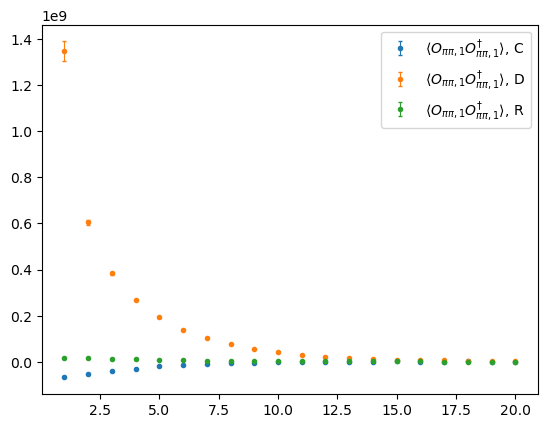

In [340]:
tsep = np.linspace(1,20,20)
fig, ax = plt.subplots()
#ax.errorbar(tsep, C_pipi_avg[0,0,:], yerr=C_pipi_err[0,0,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 0} O_{\pi\pi, 0}^{\dagger} \rangle$")
#ax.errorbar(tsep, C_pipi_p_avg[2,2,:], yerr=C_pipi_p_err[2,2,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$")
#ax.errorbar(tsep, C_pipi_p_avg[3,3,:], yerr=C_pipi_p_err[3,3,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 2} O_{\pi\pi, 2}^{\dagger} \rangle$")
#ax.errorbar(tsep, C_pipi_p_avg[4,4,:], yerr=C_pipi_p_err[4,4,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 3} O_{\pi\pi, 3}^{\dagger} \rangle$")

#ax.errorbar(tsep, pipi_type_avg[5,:], yerr=pipi_type_err[5,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 0} O_{\pi\pi, 0}^{\dagger} \rangle$, V")
#ax.errorbar(tsep, pipi_type_avg[6,:], yerr=pipi_type_err[6,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 0} O_{\pi\pi, 0}^{\dagger} \rangle$, C")
#ax.errorbar(tsep, pipi_type_avg[7,:], yerr=pipi_type_err[7,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 0} O_{\pi\pi, 0}^{\dagger} \rangle$, D")
#ax.errorbar(tsep, pipi_type_avg[8,:], yerr=pipi_type_err[8,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 0} O_{\pi\pi, 0}^{\dagger} \rangle$, R")

#ax.errorbar(tsep, pipi_p_type_avg[30,:], yerr=pipi_p_type_err[30,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, V")
ax.errorbar(tsep, pipi_p_type_avg[31,:], yerr=pipi_p_type_err[31,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, C")
ax.errorbar(tsep, pipi_p_type_avg[32,:], yerr=pipi_p_type_err[32,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, D")
ax.errorbar(tsep, pipi_p_type_avg[33,:], yerr=pipi_p_type_err[33,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, R")

#ax.errorbar(tsep, pipi_type_avg[53,:], yerr=pipi_type_err[53,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, V")
#ax.errorbar(tsep, pipi_type_avg[54,:], yerr=pipi_type_err[54,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, D")
#ax.errorbar(tsep, pipi_type_avg[55,:], yerr=pipi_type_err[55,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, C")
#ax.errorbar(tsep, pipi_type_avg[56,:], yerr=pipi_type_err[56,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$, R")

#ax.set_ylim(7.5e9, 8.5e9)
ax.legend()

#### Matrix construction and vacuum subtraction

The correlator matrix has been constructed already, we must construct another matrix of the same shape to hold the vacuum expectation values, then then do the subtraction matrix wise. We have 11 expressions in the vev array, the first being the counter, the next two being the sigma vevs, $\langle \sigma(t_{src}) \rangle$ and $\langle \sigma^{\dagger}(t_{src}) \rangle$. Then we alternate between undaggered and daggered vevs for each momentum projection. That is expressions 4 and 5 are $\langle O_{\pi\pi,0}(t_{src}) \rangle$ and $\langle O_{\pi\pi,0}^{\dagger}(t_{src}) \rangle$ and so on. 

In [681]:
vev_count = vev_arr_p[:,0,:]
vev_sigma = vev_arr_p[:,1:3,:]
vev_pipi = vev_arr_p[:,3:,:]

In [374]:
sub_mat[0,0,0,:24]

array([0.0005777 -4.23515031e-07j, 0.00055717-6.90913616e-07j,
       0.00052692-4.41499337e-07j, 0.00052776-7.59978397e-07j,
       0.0005273 -5.42610894e-07j, 0.00051258-4.24962677e-07j,
       0.00052447-6.42181686e-07j, 0.00052812-3.86223645e-07j,
       0.00052471-9.49023954e-07j, 0.0005193 -5.44118881e-07j,
       0.00053627-2.64999047e-07j, 0.00053034-5.06320666e-07j,
       0.0005387 -3.67412440e-07j, 0.00053795-5.29285182e-07j,
       0.00051236-7.20576572e-07j, 0.00054738-2.60891801e-07j,
       0.00057134-4.83818106e-07j, 0.00052638-6.06361419e-07j,
       0.00056327-5.46402159e-07j, 0.00052342-8.37314917e-07j,
       0.00052731-5.06750959e-07j, 0.00056917-7.04499047e-07j,
       0.00053193-4.85288550e-07j, 0.00054506-7.16452831e-07j])

In [373]:
sub_mat = subtraction_matrix(vev_arr_p)/(total_volume**2)

Subtraction term standard deviation: 2527855976.453451
Subtraction term standard deviation: 8180903707094.083
Subtraction term standard deviation: 1246801409.8862479
Subtraction term standard deviation: 935985130.1197587
Subtraction term standard deviation: 726386629.7844055
Subtraction term standard deviation: 8180903707094.086
Subtraction term standard deviation: 2.9401636173378612e+16
Subtraction term standard deviation: 3970365487850.2515
Subtraction term standard deviation: 2977294841662.9985
Subtraction term standard deviation: 2330805783104.227
Subtraction term standard deviation: 1246801409.8862479
Subtraction term standard deviation: 3970365487850.244
Subtraction term standard deviation: 635719430.0870891
Subtraction term standard deviation: 486934503.3701643
Subtraction term standard deviation: 381561472.9078017
Subtraction term standard deviation: 935985130.1197586
Subtraction term standard deviation: 2977294841662.9985
Subtraction term standard deviation: 486934503.37016416

In [372]:
#implementation of the vacuum subtraction term. This constructs the subtraction term for each element of the correlator mat
#the first sigma entry is the <sigma>, followed by the <sigma^\dagger>, the same structure for each momentum projection. 
def subtraction_matrix(vev_arr):
    ncf = vev_arr.shape[0]
    nexpr = vev_arr.shape[1]
    nt = vev_arr.shape[2]
    nOp = (nexpr-1)//2
    
    #normalize by the counts
    vev_count = vev_arr[:,0,:]
    vev_norm = np.zeros_like(vev_arr)
    
    for expr in range(nexpr):
        vev_norm[:, expr, :] = vev_arr[:,expr,:]#/vev_count

    #construct the subtraction term
    vev_mat = np.zeros((nOp, nOp, ncf, nt),dtype=np.complex128)
    
    for i in range(nOp):
        for j in range(nOp):
            Delta = 5
            if i == 0:
                vev1= vev_norm[:,i+3,:] 
            elif i == 1:
                Delta = 0
                vev1 = vev_norm[:,1,:]
            elif i > 1:
                vev1 = vev_norm[:, (i-1)*2+3,:]

            if j == 0:
                vev2 = vev_norm[:,j+4,:]
            elif j == 1:
                Delta=0
                vev2 = vev_norm[:,2,:]
            elif j > 1: 
                vev2 = vev_norm[:,(j-1)*2+4,:]

            
            vev_mat[i,j,:,:] = sub_term_conf(vev1, vev2, Delta)
            
    
    return vev_mat
    


#function that calculates one subtraction term given the two vevs it needs to compute the term. See the 2023 A2A pion scattering paper eq. 14
# S(t) = 1/L_t \sum_{t_src = 1}^{L_t-1} <O_i(t + t_src)> <O_j(t_src)^{\dagger}>
#Delta is an offset, necessary for the pipi * pipi terms since the second source and second sink are in the same direction. For now,
#any pipi*pipi term needs Delta=5, and any term involving the sigma needs Delta=0. 
def sub_term(Cvev1_jk, Cvev2_jk,Delta):
    nblks = Cvev1_jk.shape[0]
    t_size = Cvev1_jk.shape[-1]

    S = np.zeros((nblks,t_size),dtype=np.complex128) #this will hold the full subtraction term for each jackknife block
    for jk in range(nblks):
        for tsep in range(t_size):
            s = 0.0
            for tsrc in range(t_size):
                t_1 = (tsep + tsrc + Delta) % t_size
                s += Cvev1_jk[jk, t_1] * Cvev2_jk[jk,tsrc]

            S[jk,tsep] = s/t_size
            #print(S[tsep])

    #subtraction term should be very constant
    sub_std = np.std(S[:])
    print(f"Subtraction term standard deviation: {sub_std}")
    #assert sub_std < 1e-6, "Subtraction term not constant, standard deviation greater than 1e-6"
            
    return S

#subtraction on a configuration by configuration basis
def sub_term_conf(Cvev1, Cvev2,Delta):
    ncf, t_size = Cvev1.shape
    
    S = np.zeros((ncf,t_size),dtype=np.complex128) #this will hold the full subtraction term for each jackknife block
    for tsep in range(t_size):
        s = 0.0
        for tsrc in range(t_size):
            t_1 = (tsep + tsrc + Delta) % t_size
            s += Cvev1[:, t_1] * Cvev2[:,tsrc]

        S[:,tsep] = (s)
        #print(S[tsep])

    #subtraction term should be very constant
    sub_std = np.std(S[0,:])
    print(f"Subtraction term standard deviation: {sub_std}")
    #assert sub_std < 1e-6, "Subtraction term not constant, standard deviation greater than 1e-6"
            
    return S
    

In [371]:
t_size = 96
t_sep_size = 96
S = np.zeros(96, dtype=np.complex128)
for tsep in range(0,96):
    s = 0.0
    for tsrc in range(t_size):
        t_1 = (tsep + tsrc + 5) % t_size
        s += (vev_pipi[1,0,t_1])*(vev_pipi[1,1,tsrc])

    S[tsep] = s

NameError: name 'vev_pipi' is not defined

In [542]:
vev_pipi.shape

(55, 8, 96)

In [758]:
S1 = sub_term_conf(vev_pipi[:,0,:],vev_pipi[:,1,:],Delta=5)

Subtraction term standard deviation: 2.5458752523764047e-08


In [759]:
S[:24]

array([5.29155135e-05-1.16195369e-07j, 5.16428857e-05-9.73745068e-08j,
       5.10572029e-05-9.73047578e-08j, 5.25266238e-05-9.80165546e-08j,
       5.09508506e-05-1.28919333e-07j, 5.11437095e-05-9.98059135e-08j,
       5.18412238e-05-1.16413812e-07j, 5.08649987e-05-1.09120285e-07j,
       5.22314400e-05-1.00261750e-07j, 5.09723610e-05-1.04556861e-07j,
       5.09361486e-05-1.19356380e-07j, 5.09250576e-05-1.04868735e-07j,
       5.13674039e-05-1.51847701e-07j, 5.12344992e-05-1.01001498e-07j,
       5.13211178e-05-8.63988247e-08j, 5.14640201e-05-1.63500170e-07j,
       5.13477073e-05-9.63537138e-08j, 5.14818709e-05-1.00769763e-07j,
       5.08448377e-05-1.03742343e-07j, 5.09878846e-05-5.96532078e-08j,
       5.15591301e-05-1.80423063e-07j, 5.11637013e-05-1.19991623e-07j,
       5.14586027e-05-9.82590781e-08j, 5.15110966e-05-1.18655508e-07j])

In [752]:
sub_mat[0,0,1,:24]

array([1.07349001e-06-1.37686573e-09j, 9.95105729e-07-1.76998355e-09j,
       9.87362767e-07-1.51987511e-09j, 9.95788237e-07-9.21003316e-10j,
       1.00621178e-06-1.31921139e-09j, 1.01204609e-06-1.13887022e-09j,
       1.01544222e-06-2.16401910e-09j, 9.80978824e-07-1.61592454e-09j,
       9.90399858e-07-1.16868464e-09j, 1.01275215e-06-9.52518895e-10j,
       9.93437599e-07-1.55608879e-09j, 9.99883655e-07-1.26351607e-09j,
       9.77763524e-07-2.52932223e-09j, 1.00276912e-06-1.15116716e-09j,
       1.01482145e-06-6.29062635e-10j, 9.89910030e-07-2.89141095e-09j,
       9.79950044e-07-1.01591975e-09j, 9.85612710e-07-1.97082256e-09j,
       1.01533135e-06-1.48719006e-09j, 9.81004732e-07-4.52413812e-10j,
       9.73707432e-07-3.24474560e-09j, 9.73214008e-07-1.41541125e-09j,
       9.85638240e-07-1.38632378e-09j, 1.01242589e-06-1.74127328e-09j])

In [731]:
sub_mat.shape

(5, 5, 55, 96)

In [732]:
C_pipi_sum.shape

(5, 5, 55, 20)

In [375]:
tsep_max = 20
C_pipi_sub = np.zeros_like(C_pipi_p_sum2)
for tsep in range(tsep_max):
    C_pipi_sub[:,:,:,tsep] = C_pipi_p_sum2[:,:,:,tsep] - sub_mat[:,:,:,tsep]

In [361]:
sub_mat[0,0,0,:24]*total_volume

array([0.42345169-0.00027885j, 0.40602509-0.00057091j,
       0.40066739-0.00045549j, 0.40404771-0.00049524j,
       0.41170442-0.00050356j, 0.40289477-0.00032311j,
       0.39781171-0.00051386j, 0.40166708-0.00037686j,
       0.40113279-0.00055869j, 0.40574441-0.00050434j,
       0.40951351-0.00018415j, 0.40160791-0.00034498j,
       0.4064905 -0.00043301j, 0.40652368-0.00041242j,
       0.41015495-0.00042175j, 0.41406719-0.00026562j,
       0.41141086-0.00043563j, 0.40076008-0.00053445j,
       0.41665653-0.00048593j, 0.40762999-0.00050243j,
       0.40673116-0.00041087j, 0.41150039-0.00054733j,
       0.4026251 -0.00032802j, 0.41335114-0.00037091j])

In [357]:
C_sub_avg[0,0,:]

array([0.00099073, 0.00080847, 0.00074883, 0.00071492, 0.00068671,
       0.00066203, 0.0006432 , 0.00062445, 0.00061391, 0.00060264,
       0.00059198, 0.00058285, 0.00057566, 0.00057041, 0.00056732,
       0.00056169, 0.00055482, 0.00055548, 0.00055138, 0.00055053])

In [376]:
C_pipi_sub_jk = jackblocks_mat(C_pipi_sub, omit=[])

In [377]:
C_sub_avg = np.zeros((nOp, nOp, tsep_max))
C_sub_err = np.zeros((nOp, nOp, tsep_max))
for i in range(nOp):
    for j in range(nOp):
        C_sub_avg[i,j,:], C_sub_err[i,j,:] = jack(C_pipi_sub_jk[i,j,:].real)

<ErrorbarContainer object of 3 artists>

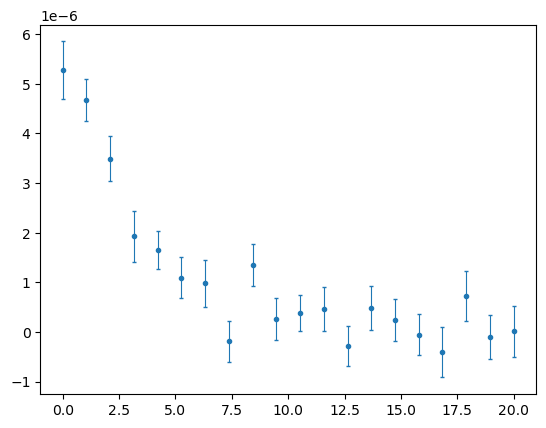

In [379]:
tsep = np.linspace(0,20,20)
fig, ax = plt.subplots()

#ax.errorbar(tsep, C_pipi_p_avg[0,0,:], yerr=C_pipi_p_err[0,0,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 2} O_{\pi\pi, 2}^{\dagger} \rangle$")

#ax.errorbar(tsep, C_sub_avg[0,0,:], yerr=C_sub_err[0,0,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 0} O_{\pi\pi, 0}^{\dagger} \rangle$")
#ax.errorbar(tsep, C_sub_avg[2,2,:], yerr=C_sub_err[2,2,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 1} O_{\pi\pi, 1}^{\dagger} \rangle$")
#ax.errorbar(tsep, C_sub_avg[3,3,:], yerr=C_sub_err[3,3,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 2} O_{\pi\pi, 2}^{\dagger} \rangle$")
#ax.errorbar(tsep, C_sub_avg[4,4,:], yerr=C_sub_err[4,4,:], marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi, 3} O_{\pi\pi, 3}^{\dagger} \rangle$")
#ax.set_ylim(-1e-6, 1e-6)

#### Leftovers

In [113]:
nexpr=5
pi_sigma_arr = np.zeros((ncf_pipi-1,nexpr,tsep_max),dtype=np.complex128)
sigma_pi_arr = np.zeros((ncf_pipi-1,nexpr,tsep_max),dtype=np.complex128)

pi_sigma_arr[:,:,:] = sigpi_arr[:,:,:,0]
sigma_pi_arr[:,:,:] = sigpi_arr[:,:,:,1]

In [114]:
pipi_type_jk = jackblocks_expr(pipi_type_arr,omit=[])
vev2_arr_jk = jackblocks_expr(vev2_arr, omit=[])
pipi_type_avg, pipi_type_err = jack(pipi_type_jk)

In [115]:
pipi_arr_jk = jackblocks_expr(pipi_arr,omit=[])
pi_sig_jk = jackblocks_expr(pi_sigma_arr,omit=[])
sig_pi_jk = jackblocks_expr(sigma_pi_arr,omit=[])
vev_arr_jk = jackblocks_expr(vev_arr, omit=[])

In [116]:
pipi_arr_jk.shape

(23, 17, 19)

In [117]:
pipi_type_arr.shape

(23, 65, 19)

In [118]:
C_total = full_corr_sum(pipi_type_arr, 4, 4)
C_total.shape

(4, 4, 23, 19)

In [89]:
C_total_jks = jackblocks_mat(C_total,omit=[])
C_total_jks.shape

(4, 4, 23, 19)

In [119]:
Ct_000_avg, Ct_000_err = jack(C_total_jks[0,0,:,:])
Ct_001_avg, Ct_001_err = jack(C_total_jks[1,1,:,:])
Ct_011_avg, Ct_011_err = jack(C_total_jks[2,2,:,:])
Ct_111_avg, Ct_111_err = jack(C_total_jks[3,3,:,:])
Ct_000_avg.shape

(19,)

In [136]:
np.linspace(2,20,19)

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20.])

In [120]:
pipi_avg, pipi_err = jack(pipi_arr_jk)
pi_sig_avg, pi_sig_err = jack(pi_sig_jk)
sig_pi_avg, sig_pi_err = jack(sig_pi_jk)
vev_avg, vev_err = jack(vev_arr_jk)

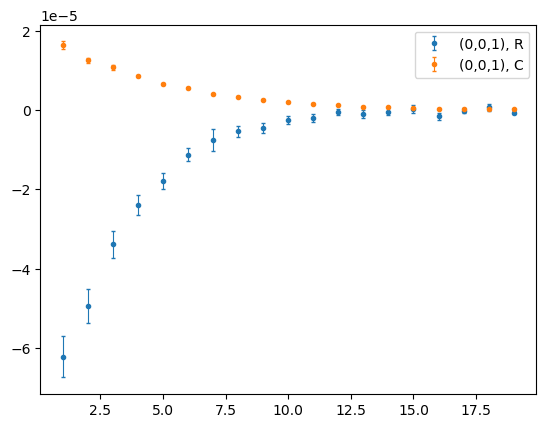

In [143]:
t_sep = np.linspace(1,19,19)
fig, ax = plt.subplots()
#ax.errorbar(t_sep, pipi_avg[1,:].real, yerr=pipi_err[1,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), total")
#ax.errorbar(t_sep, pipi_avg[6,:].real, yerr=pipi_err[6,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,1)")
#ax.errorbar(t_sep, pipi_avg[11,:].real, yerr=pipi_err[11,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,1,1)")
#ax.errorbar(t_sep, pipi_avg[16,:].real, yerr=pipi_err[16,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(1,1,1)")

#ax.errorbar(t_sep, pipi_type_avg[1,:].real, yerr=pipi_type_err[1,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), V")
#ax.errorbar(t_sep, pipi_type_avg[2,:].real, yerr=pipi_type_err[2,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), R")
#ax.errorbar(t_sep, pipi_type_avg[3,:].real, yerr=pipi_type_err[3,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), D")
#ax.errorbar(t_sep, pipi_type_avg[4,:].real, yerr=pipi_type_err[4,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), C")

#ax.errorbar(t_sep, pipi_type_avg[5,:].real, yerr=pipi_type_err[1,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), V")
#ax.errorbar(t_sep, pipi_type_avg[6,:].real, yerr=pipi_type_err[2,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), R")
#ax.errorbar(t_sep, pipi_type_avg[7,:].real, yerr=pipi_type_err[3,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), D")
#ax.errorbar(t_sep, pipi_type_avg[8,:].real, yerr=pipi_type_err[4,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), C")

#ax.errorbar(t_sep, pipi_type_avg[21,:].real, yerr=pipi_type_err[21,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,1), V")
#ax.errorbar(t_sep, pipi_type_avg[22,:].real, yerr=pipi_type_err[22,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,1), R")
#ax.errorbar(t_sep, pipi_type_avg[23,:].real, yerr=pipi_type_err[23,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,1), D")
#ax.errorbar(t_sep, pipi_type_avg[24,:].real, yerr=pipi_type_err[24,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,1), C")

#ax.errorbar(t_sep, pipi_type_avg[41,:].real, yerr=pipi_type_err[41,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,1,1), V")
#ax.errorbar(t_sep, pipi_type_avg[42,:].real, yerr=pipi_type_err[42,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,1,1), R")
#ax.errorbar(t_sep, pipi_type_avg[43,:].real, yerr=pipi_type_err[43,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,1,1), D")
#ax.errorbar(t_sep, pipi_type_avg[44,:].real, yerr=pipi_type_err[44,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,1,1), C")

#ax.errorbar(t_sep, pipi_type_avg[61,:].real, yerr=pipi_type_err[61,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(1,1,1), V")
#ax.errorbar(t_sep, pipi_type_avg[62,:].real, yerr=pipi_type_err[62,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(1,1,1), R")
#ax.errorbar(t_sep, pipi_type_avg[63,:].real, yerr=pipi_type_err[63,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(1,1,1), D")
#ax.errorbar(t_sep, pipi_type_avg[64,:].real, yerr=pipi_type_err[64,:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(1,1,1), C")

#ax.errorbar(t_sep, 96*Cs_000_avg[:].real, yerr=Cs_000_err[:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), S")
#ax.errorbar(t_sep, 96*Cs_001_avg[:].real, yerr=Cs_001_err[:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,1), S")
#ax.errorbar(t_sep, 96*Cs_011_avg[:].real, yerr=Cs_011_err[:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,1,1) S")
#ax.errorbar(t_sep, 96*Cs_111_avg[:].real, yerr=Cs_111_err[:].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(1,1,1) S")

#ax.errorbar(t_sep, Ct_000_avg.real, yerr=Ct_000_err.real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,0), sum")
#ax.errorbar(t_sep, Ct_001_avg.real, yerr=Ct_001_err.real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,0,1), sum",)
#ax.errorbar(t_sep, Ct_011_avg.real, yerr=Ct_011_err.real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(0,1,1)")
#ax.errorbar(t_sep, Ct_111_avg.real, yerr=Ct_111_err.real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label="(1,1,1)")

#ax.set_ylim(0.00, 0.0001)
ax.legend();

In [ ]:
## nOp = 4
ncf, nexpr, tsep_max = pipi_arr_jk.shape
nt = vev_arr_jk.shape[-1]
pipi_4b4_jk = np.zeros((nOp, nOp, ncf, tsep_max),dtype=np.complex128)
vev1_pipi_jk = np.zeros((nOp, ncf, nt),dtype=np.complex128)
vev2_pipi_jk = np.zeros((nOp, ncf, nt),dtype=np.complex128)
vev1_sigma_jk = np.zeros((ncf, nt),dtype=np.complex128)
vev2_sigma_jk = np.zeros((ncf, nt),dtype=np.complex128)


for op1 in range(nOp):
    for op2 in range(nOp):
        pipi_4b4_jk[op1, op2,:,:] = pipi_arr_jk[:,(op1*4 + op2)+1,:]

vev1_sigma_jk = vev_arr_jk[:,1,:]
vev2_sigma_jk = vev_arr_jk[:,2,:]

#pulling out each independent term from the vev data array to use in a convenient way
for op1 in range(nOp):
    vev1_pipi_jk[op1,:,:] = vev_arr_jk[:,(op1*2 + 0)+3,:]
    vev2_pipi_jk[op1,:,:] = vev_arr_jk[:,(op1*2 + 1)+3,:]

In [46]:
Cs = np.zeros_like(pipi_4b4_jk)

for op1 in range(nOp):
    for op2 in range(nOp):
        Cs[op1,op2,:,:] = vac_sub(pipi_4b4_jk[op1,op2,:,:], vev1_pipi_jk[op1,:,:], vev2_pipi_jk[op2,:,:])
        

(0.05223817705799709-1.1063901758013385e-05j)
Subtraction term standard deviation: 3.5852250648643817e-05
(0.01934285950453711-7.97350838412681e-06j)
Subtraction term standard deviation: 1.4698694301205288e-05
(0.0117328198055314-6.217547086498562e-06j)
Subtraction term standard deviation: 1.049759870729629e-05
(0.0082096369753282-4.597562637654677e-06j)
Subtraction term standard deviation: 8.433976074330121e-06
(0.019327891281218864-8.01433056336936e-06j)
Subtraction term standard deviation: 1.342135124891087e-05
(0.007156814687461551-4.439601954606703e-06j)
Subtraction term standard deviation: 5.718306139121612e-06
(0.004341636212657434-3.188302198096012e-06j)
Subtraction term standard deviation: 4.1595433677675305e-06
(0.0030375228743284985-2.3347321092043223e-06j)
Subtraction term standard deviation: 3.220698741427413e-06
(0.011720590843092075-6.2542708780054236e-06j)
Subtraction term standard deviation: 9.63189784361376e-06
(0.004339808503689795-3.2521607395501152e-06j)
Subtractio

In [1015]:
nt

96

In [49]:
tsep = 19
Cs_avg = np.zeros((nOp, nOp, tsep),dtype=np.complex128)
Cs_err = np.zeros((nOp, nOp, tsep),dtype=np.complex128)
for i in range(nOp):
    for j in range(nOp):
        Cs_avg[i,j,:], Cs_err[i,j,:] = jack(Cs[i,j,:,:])

In [704]:
Cs_000_avg, Cs_000_err = jack(Cs[0,0,:,:])
Cs_001_avg, Cs_001_err = jack(Cs[1,1,:,:])
Cs_011_avg, Cs_011_err = jack(Cs[2,2,:,:])
Cs_111_avg, Cs_111_err = jack(Cs[3,3,:,:])

In [321]:
(np.sum(vev1_sigma_avg[:])*(total_volume)/(2048))*(np.sum(vev1_sigma_avg[:])*(total_volume)/(2048))/96

np.complex128(14979.502276945987-4.914288940606937j)

In [409]:
vev1_sigma_avg, vev1_sigma_err = jack(vev1_sigma_jk)

In [51]:
pipi_avg.shape

(17, 19)

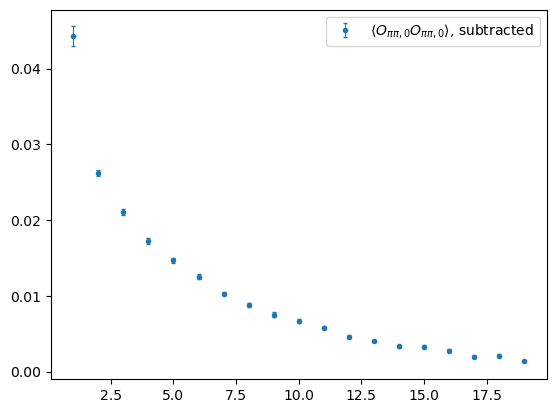

In [149]:
tsep = np.linspace(1,19,19)
t = np.linspace(0,95,96)
fig, ax = plt.subplots()

#ax.errorbar(tsep, pipi_avg[3].real, yerr=pipi_err[3].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,0} O_{\pi\pi,0} \rangle$")
#ax.errorbar(tsep, pipi_avg[6].real, yerr=pipi_err[6].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,0} O_{\pi\pi,0} \rangle$")
#ax.errorbar(tsep, pipi_avg[11].real, yerr=pipi_err[11].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,0} O_{\pi\pi,0} \rangle$")
#ax.errorbar(tsep, pipi_avg[16].real, yerr=pipi_err[16].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,3} O_{\pi\pi,3} \rangle$")

#ax.errorbar(tsep, pipi_avg[3].real, yerr=pipi_err[3].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,0} O_{\pi\pi,0} \rangle$")


ax.errorbar(tsep, Cs_avg[0,0].real, yerr=Cs_err[0,0].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,0} O_{\pi\pi,0} \rangle$, subtracted")
#ax.errorbar(tsep, Cs_avg[0,2].real, yerr=Cs_err[0,2].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,0} O_{\pi\pi,0} \rangle$")
#ax.errorbar(tsep, Cs_avg[1,1].real, yerr=Cs_err[1,1].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,1} O_{\pi\pi,1} \rangle$")
#ax.errorbar(tsep, Cs_avg[2,2].real, yerr=Cs_err[2,2].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,2} O_{\pi\pi,2} \rangle$")
#ax.errorbar(tsep, Cs_avg[3,3].real, yerr=Cs_err[3,3].real, marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,3} O_{\pi\pi,3} \rangle$")

#ax.errorbar(tsep, Cs_001_avg.real, yerr=Cs_001_err.real, marker='.', ls='', elinewidth=0.8, capsize=1.5)
#ax.errorbar(t, vev1_sigma_avg.real, yerr=vev1_sigma_err.real, marker='.', ls='', elinewidth=0.8, capsize=1.5)
#ax.set_ylim(-0.005, -0.001)
ax.legend();

In [150]:
Cs_err[0,0]

array([0.00130526-1.31589751e-06j, 0.00040378+1.32364319e-06j,
       0.00037072+3.17285130e-06j, 0.00038549+1.01060970e-07j,
       0.000335  -6.14691754e-07j, 0.0003042 -3.93860905e-07j,
       0.00022838+1.62343153e-06j, 0.00024611+7.16847112e-07j,
       0.00028483-2.77396313e-07j, 0.00024123+8.42785575e-07j,
       0.00022034+4.71339837e-07j, 0.00018259+1.09382343e-06j,
       0.00019223-6.39832812e-07j, 0.00019709+7.97151675e-07j,
       0.0001816 -9.68685008e-07j, 0.00023229-5.90303497e-07j,
       0.00019561+1.22793045e-06j, 0.00020373+6.47631791e-07j,
       0.0001626 +3.19699741e-07j])

### Cross-term anaysis and subtraction

In [974]:
vev_arr_jk.shape
ncf = vev_arr_jk.shape[0]
nt = vev_arr_jk.shape[-1]
pi_vev1_jk = np.zeros((ncf, 4, nt),dtype=np.complex128)
pi_vev2_jk = np.zeros((ncf, 4, nt),dtype=np.complex128)
tsep_max = 19
k=0
for i in range(3,10,2):
    pi_vev1_jk[:,k,:] = vev_arr_jk[:,i,:]
    pi_vev2_jk[:,k,:] = vev_arr_jk[:,i+1,:]
    k+=1

In [975]:
pi_vev1_jk.shape

(50, 4, 96)

In [996]:
sig_pi_jk.shape

(50, 5, 19)

In [997]:
pi_sigma_sub = np.zeros((ncf, 4, tsep_max),dtype=np.complex128)
sigma_pi_sub = np.zeros((ncf, 4, tsep_max),dtype=np.complex128)

for i in range(4):
    pi_sigma_sub[:37, i, : ] = vac_sub(pi_sig_jk[:37,i+1,:], pi_vev1_jk[:37,i,:], sigma_vev_jk[:,0,:])
    sigma_pi_sub[:37, i, : ] = vac_sub(sig_pi_jk[:37,i+1,:], sigma_vev_jk[:,0,:], pi_vev2_jk[:37,i,:])

(0.052792065650751126-1.0601918688293816e-05j)
Subtraction term standard deviation: 2.3034447414163098e-05
(0.05288723612282549-9.64308663683718e-06j)
Subtraction term standard deviation: 3.679478474520772e-05
(0.019503180846059363-7.999754022991518e-06j)
Subtraction term standard deviation: 1.0214082542728667e-05
(0.019547394856299076-7.607045748604213e-06j)
Subtraction term standard deviation: 1.4417034699200013e-05
(0.01181839912423446-6.051943767473601e-06j)
Subtraction term standard deviation: 7.631701598232377e-06
(0.011846167077020946-5.823754006844229e-06j)
Subtraction term standard deviation: 9.858421689337137e-06
(0.008268068466004752-4.717380652772808e-06j)
Subtraction term standard deviation: 7.100723788475187e-06
(0.00829107032615193-4.357356509897343e-06j)
Subtraction term standard deviation: 8.145389788982433e-06


In [998]:
pi_sigma_sub_avg, pi_sigma_sub_err = jack(pi_sigma_sub)
pi_sig_avg, pi_sig_err = jack(pi_sig_jk)

sigma_pi_sub_avg, sigma_pi_sub_err = jack(pi_sigma_sub)
sig_pi_avg, sig_pi_err = jack(pi_sig_jk)

In [1003]:
sigma_pi_sub_avg.shape

(4, 19)

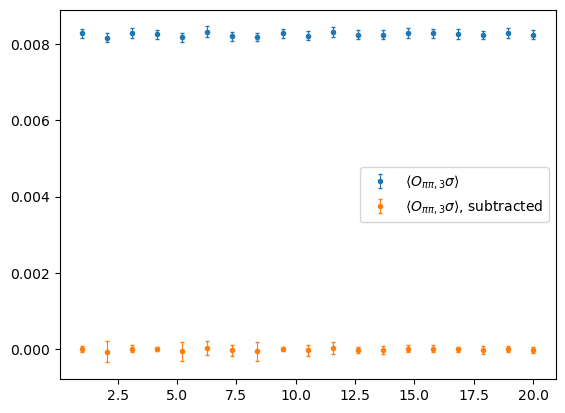

In [1011]:
tsep = np.linspace(1,20,19)
fig, ax = plt.subplots()
#ax.errorbar(tsep, pi_sig_avg[1,:], yerr = pi_sig_err[1,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle  O_{\pi\pi,0} \sigma\rangle$")
#ax.errorbar(tsep, pi_sig_avg[2,:], yerr = pi_sig_err[2,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle  O_{\pi\pi,1} \sigma\rangle$")
#ax.errorbar(tsep, pi_sig_avg[3,:], yerr = pi_sig_err[3,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle  O_{\pi\pi,2} \sigma\rangle$")
ax.errorbar(tsep, pi_sig_avg[4,:], yerr = pi_sig_err[4,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle  O_{\pi\pi,3} \sigma\rangle$")

#ax.errorbar(tsep, sig_pi_avg[1,:], yerr = sig_pi_err[1,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,0} \rangle$")
#ax.errorbar(tsep, sig_pi_avg[2,:], yerr = sig_pi_err[2,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,1} \rangle$")
#ax.errorbar(tsep, sig_pi_avg[3,:], yerr = sig_pi_err[3,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,2} \rangle$")
#ax.errorbar(tsep, sig_pi_avg[4,:], yerr = sig_pi_err[4,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,3} \rangle$")

#ax.errorbar(tsep, sigma_pi_sub_avg[0,:], yerr = pi_sigma_sub_err[0,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,0} \rangle$, subtracted")
#ax.errorbar(tsep, sigma_pi_sub_avg[1,:], yerr = pi_sigma_sub_err[1,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,1} \rangle$, subtracted")
#ax.errorbar(tsep, sigma_pi_sub_avg[2,:], yerr = pi_sigma_sub_err[2,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,2} \rangle$, subtracted")
#ax.errorbar(tsep, sigma_pi_sub_avg[3,:], yerr = pi_sigma_sub_err[3,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle \sigma O_{\pi\pi,3} \rangle$, subtracted")

#ax.errorbar(tsep, pi_sigma_sub_avg[0,:], yerr = pi_sigma_sub_err[0,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,0} \sigma \rangle$, subtracted")
#ax.errorbar(tsep, pi_sigma_sub_avg[1,:], yerr = pi_sigma_sub_err[1,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,1} \sigma \rangle$, subtracted")
#ax.errorbar(tsep, pi_sigma_sub_avg[2,:], yerr = pi_sigma_sub_err[2,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,2} \sigma \rangle$, subtracted")
ax.errorbar(tsep, pi_sigma_sub_avg[3,:], yerr = pi_sigma_sub_err[3,:],marker='.', ls='', elinewidth=0.8, capsize=1.5, label=r"$\langle O_{\pi\pi,3} \sigma \rangle$, subtracted")

#ax.set_ylim(-0.001, 0.06)
ax.legend();

### 4x4 GEVP (no sigma)

In [430]:
#changing the 5x5 matrix we have into a 4x4 
nOp = 2

C_sub_4b4 = np.delete(np.delete(C_pipi_sub_jk,1,axis=0),1,axis=1)

C_sub_3b3 = np.delete(np.delete(C_sub_4b4, 3, axis=0),3,axis=1)
C_sub_2b2 = np.delete(np.delete(C_sub_3b3, 2, axis=0),2,axis=1)

In [431]:
C_sub_2b2.shape

(2, 2, 84, 20)

In [408]:
reg = np.zeros_like(C_sub_4b4[0,0,:,:])
reg += 2e-7

In [409]:
C_sub_4b4_reg = C_sub_4b4 + reg

In [410]:
C_sub_4b4_reg[3,3,0,:]

array([ 1.25901925e-06+1.23462048e-08j,  5.56525057e-07-2.22376930e-09j,
        8.40277192e-07-2.66690755e-09j, -9.18053425e-09+4.41675786e-09j,
        3.42110186e-07-4.26256166e-09j,  2.32283880e-07-8.89630402e-10j,
        2.50615472e-07-3.47836749e-09j,  1.04014035e-08+7.96696945e-09j,
        5.00971988e-07+4.50636921e-09j,  1.47895260e-07-6.76498397e-09j,
        2.45336274e-07-4.19408974e-09j,  3.85534534e-07+9.57220257e-09j,
        6.02351724e-08-1.08980204e-08j,  3.00304004e-07+9.61877654e-09j,
        1.58379343e-07-1.64476937e-09j,  6.18047593e-08-1.12436967e-08j,
        2.17106896e-07+1.41572100e-08j,  3.28627478e-07-3.72422076e-09j,
        2.21509368e-07-3.60541871e-09j,  1.11892665e-07-4.26874868e-09j])

In [466]:
l48I_I0D5 = Ensemble_jks(C_sub_3b3)

In [467]:
l48I_I0D5.jks.shape

(3, 3, 84, 20)

In [472]:
minOp = 0
maxOp = 2
tmin  = 2
tmax  = 8
GEVP(l48I_I0D5, minOp, maxOp, tmin, tmax)

/tmp/ipykernel_2714810/431032691.py:22: ComplexWarning: Casting complex values to real discards the imaginary part
  ens_params.vec[cf,t] = vec_desc


LinAlgError: The leading minor of order 3 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

In [462]:
l48I_I0D5.e[82,:,0]

array([0.        , 0.        , 0.80249205, 0.84446565, 0.9190785 ,
       0.84262191, 0.88585551, 0.85413943, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [463]:
t1=2
t2=7
fpD5d25, fcD5d25 = ex_fit_ln(l48I_I0D5.ncf,l48I_I0D5.e,l48I_I0D5.nOp,t1,t2)

n, chi square, dof= 0 (np.float64(0.8895886855539868), np.float64(1.7183307608266178)) 4
p-value= 0.9297438031152454
----------------------------------------
n, chi square, dof= 1 (np.float64(1.0228862376032277), np.float64(1.6170806946837715)) 4
p-value= 0.9109991804750852
----------------------------------------


Energy= 0 0.17256426037849118 0.013884725754364472
----------------------------------------------------
Energy= 1 0.3190977836337024 0.05940208870079596
----------------------------------------------------


/tmp/ipykernel_2714810/3675943357.py:6: RuntimeWarning: invalid value encountered in log
  v,err=jack(-np.log(l48I_I0D5.e[:,tmin:tmax,l]))


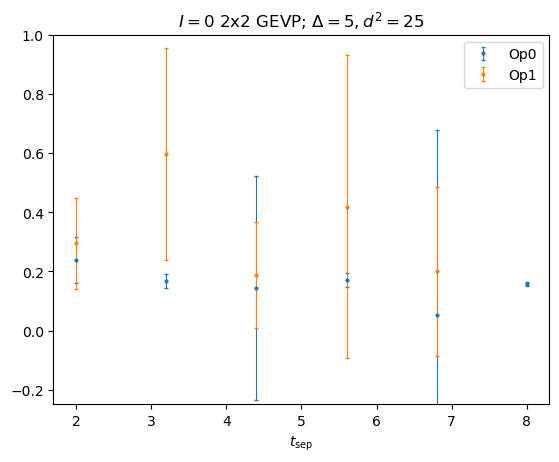

In [465]:
fig5, ax5 = plt.subplots()
a_inv = 1.73
#excited states
t = np.linspace(2,8,6)
for l in range(0,maxOp):
    v,err=jack(-np.log(l48I_I0D5.e[:,tmin:tmax,l]))
    ax5.errorbar(t,v,err,marker='o',linestyle='',elinewidth=0.8,markersize=2,capsize=1.5,label='Op'+str(l))
    v,err=jack(fpD5d25[l,:,0])
    print('Energy=',l,v,err)
    print("----------------------------------------------------")

ax5.set_ylim(-0.25,1)
#ax5.set_xlim(1,14)
ax5.set_xlabel(r"$t_{\text{sep}}$")
ax5.set_title(r"$I=0$ 2x2 GEVP; $\Delta=5, d^2 = 25$")
ax5.legend();

### Improved vacuum subtraction

In [520]:
dst = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pipi-dc-sub/traj-1422/pipi_vev_pos.lat"
#dst_nosub = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pipi-avg-pos/traj-1132/pipi_vev_pos.lat"
ld_pos = q.load_lat_data(dst)
#ld_nosub = q.load_lat_data(dst_nosub)

In [521]:
q.display_info(ld_pos.info())

[['expr_name', 3, ['< 1 >  exprs[0]', '< wf_src(0) * pipi_i0(-tsep) >  exprs[1]', '< wf_snk(0) * pipi_i0^dag(0) >  exprs[2]']], ['x_rel', 25, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']], ['y_rel', 25, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']], ['z_rel', 25, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24']], ['t_src', 96, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', 

In [522]:
arr_pos = ld_pos.to_numpy()
#arr_nosub = ld_nosub.to_numpy()
print(arr_pos.shape)

(3, 25, 25, 25, 96)


In [506]:
arr_t = np.sum(np.sum(np.sum(arr_pos,axis=3),axis=2), axis=1)/(total_volume)

In [200]:
counter = arr_nosub[0,:,:,:]
avg = np.zeros_like(arr_nosub)
mask = counter != 0

avg[:,mask] = arr_nosub[:,mask]/counter[mask]

In [201]:
avg.shape

(3, 25, 25, 25)

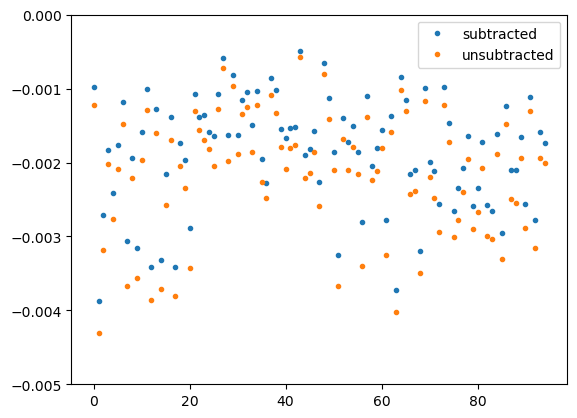

In [512]:
t = np.linspace(0,94,95)
fig, ax = plt.subplots()
ax.plot()
#ax.plot(t, arr_pp[6,:]/(total_volume**2), marker='.', ls='')
ax.plot(t, arr_t[1,1:],marker='.', ls='',label='subtracted')
ax.plot(t, arr_t[2,1:],marker='.', ls='',label='unsubtracted')
ax.set_ylim(-0.005,0)
ax.legend()

In [207]:
arr_pp[6,:]/(total_volume**2)

array([0.00050585+2.11183490e-07j, 0.00049896+2.83970025e-07j,
       0.00051585+1.96811119e-07j, 0.00050465-1.10561699e-08j,
       0.00050283-1.93164969e-08j, 0.00050176+4.21332279e-07j,
       0.00049383+9.19050666e-08j, 0.00051481-4.07491947e-08j,
       0.00050194-2.81815494e-08j, 0.00050785+1.67425195e-07j,
       0.00051359+3.88460845e-07j, 0.00051165-5.11665659e-08j,
       0.00052285-1.12966791e-07j, 0.00051147+4.46923824e-08j,
       0.00051842+5.32204066e-09j, 0.00052447-2.57390198e-08j,
       0.000528  +2.25986902e-08j, 0.0005242 +1.24616069e-07j,
       0.00052089+2.94707410e-07j, 0.00052205+1.40713884e-09j])

In [210]:
acc_t[1:21]

array([4.61895901e+07-1490806.47366675j, 2.06769071e+07 -235131.83891958j,
       5.73536875e+07 -129398.79878017j, 1.59673111e+08 +219842.25762543j,
       1.83056818e+07  +14724.77834249j, 2.43442866e+07 +128543.08023683j,
       1.21138878e+07-2191144.60818509j, 1.95117160e+07 +132675.11508977j,
       3.44659491e+07 -652861.43160391j, 5.75266704e+06  -26061.66119661j,
       3.48399746e+07 -362325.54022552j, 2.52031112e+07 +546126.92172501j,
       3.05543575e+07+1927194.89242821j, 3.40748710e+07 +177783.2637954j ,
       8.55142720e+06  +32100.63501303j, 6.49403119e+07 +932022.3269124j ,
       2.05931699e+07  +63986.74975103j, 5.18487238e+07 -297126.47046846j,
       4.84289782e+07  +95142.12520089j, 2.33301120e+08 -404643.54445858j])

In [75]:
arr_Avg = np.divide(pipi_vev, counter, where=(counter!=0))

In [78]:
arr_Avg[0,0,0,:24]

array([-9.30207789e-03-9.74916236e-08j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
       -3.60492404e-04-2.36015652e-07j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -1.09654795e-05-4.66299115e-08j,
        0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j, -1.22300319e-06-1.76914869e-08j,
       -8.12570097e-07-4.78094006e-09j, -3.15053789e-06+2.80459326e-08j,
        0.00000000e+00+0.00000000e+00j, -1.57560381e-06-1.52704996e-09j,
       -4.89905777e-07+2.74586843e-09j,  0.00000000e+00+0.00000000e+00j,
       -1.04580536e-06+2.00851718e-08j, -4.30303173e-07+1.05554137e-08j])

In [570]:
dst_avg = "/home/jhildebrand28/ktopipi/results/48I/auto-contract-pipi-pos-avg/"
avg_data = []


for traj in range(1112, 1493, 10):
    avg_data.append(q.load_lat_data(dst_avg+f"traj-{traj}/pipi_vev_pos_avg.lat").to_numpy())

for traj in range(1705, 1796, 10):
    avg_data.append(q.load_lat_data(dst_avg+f"traj-{traj}/pipi_vev_pos_avg.lat").to_numpy())

avg_arr = np.array(avg_data)
print(avg_arr.shape)

(49, 3, 25, 25, 25)


In [516]:
avg_arr_t = np.sum(np.sum(np.sum(avg_arr,axis=4),axis=3),axis=2)

In [519]:
avg_arr_t[0,0]

np.complex128(1172318220288.0002+0j)

In [571]:
#first do the average with the counter array per configuration
ncf = len(avg_data)
NS_mod = avg_arr.shape[-1]
pipi_avg_arr = np.zeros((ncf, NS_mod, NS_mod, NS_mod),np.complex128)
for cf in range(ncf):
    counter = avg_arr[cf,0,:,:,:]
    mask = (counter != 0) #we only want to divide by entries that are non-zero
    pipi_avg_arr[cf, mask] = avg_arr[cf,1,mask]#/counter[mask]

print(pipi_avg_arr.shape)

(49, 25, 25, 25)


In [572]:
pipi_avg_jk = jackblocks_pos(pipi_avg_arr, omit=[])
print(pipi_avg_jk.shape)

(49, 25, 25, 25)


In [573]:
pipi_avg_avg, pipi_avg_err = jack(pipi_avg_jk)
pipi_avg_whole = np.array([pipi_avg_avg, pipi_avg_err])
print(pipi_avg_avg.shape)
#np.save("pipi_avg_data", pipi_avg_avg)

(25, 25, 25)


In [574]:
pipi_x = np.sum(np.sum(pipi_avg_jk,axis=3),axis=2)
pipi_y = np.sum(np.sum(pipi_avg_jk,axis=3),axis=1)
pipi_z = np.sum(np.sum(pipi_avg_jk,axis=2),axis=1)

In [575]:
pipi_x_avg, pipi_x_err = jack(pipi_x.real)
pipi_y_avg, pipi_y_err = jack(pipi_y.real)
pipi_z_avg, pipi_z_err = jack(pipi_z.real)

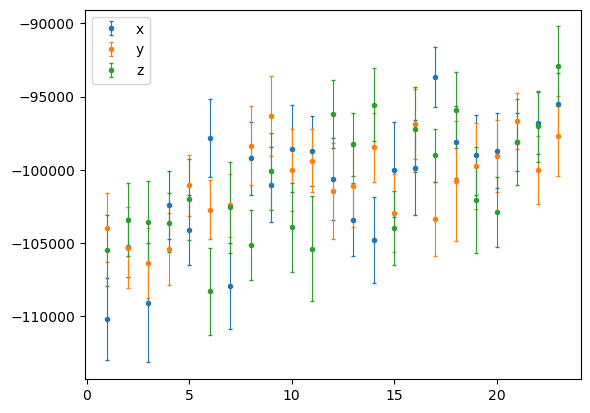

In [577]:
t = np.linspace(1,23,23)
fig, ax = plt.subplots()
ax.errorbar(t, pipi_x_avg[1:24], yerr=pipi_x_err[1:24],marker='.',ls='',elinewidth=0.8,capsize=1.5,label="x")
ax.errorbar(t, pipi_y_avg[1:24], yerr=pipi_y_err[1:24],marker='.',ls='',elinewidth=0.8,capsize=1.5,label="y")
ax.errorbar(t, pipi_z_avg[1:24], yerr=pipi_z_err[1:24],marker='.',ls='',elinewidth=0.8,capsize=1.5,label="z")
#ax.set_ylim(-0.000250, -0.0001)
ax.legend();

In [530]:
arr_space = np.sum(arr_pos,axis=4)

In [544]:
sub = arr_space[1,:,:,:] - (pipi_avg_avg[:,:,:]*49)

In [545]:
sub.shape

(25, 25, 25)

In [579]:
np.sum(np.sum(np.sum(pipi_avg_avg,axis=2),axis=1),axis=0)

np.complex128(-25260.29919044236+2.7065467994155687j)

In [600]:
arrT_nosub = np.sum(np.sum(np.sum(arr_pos[2,:,:,:,:],axis=2),axis=1),axis=0)
arrT_sub = np.sum(np.sum(np.sum(arr_pos[1,:,:,:,:],axis=2),axis=1),axis=0)

In [603]:
np.sum(arrT_nosub)

np.complex128(-2214521.38283518+1.5948421498229663j)

In [581]:
arr_pos.shape

(3, 25, 25, 25, 96)

In [582]:
arr_nosub = arr_pos[2,:,:,:,:]
arr_sub = arr_pos[1,:,:,:,:]

In [590]:
sub = np.zeros((96))
for t in range(96):
    for x in range(25):
        for y in range(25):
            for z in range(25):
                sub[t] += (arr_nosub[x,y,z,t] - pipi_avg_avg[x,y,z])

/tmp/ipykernel_2714810/2871555250.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  sub[t] += (arr_nosub[x,y,z,t] - pipi_avg_avg[x,y,z])


In [612]:
pipi_avg_avg[1,2,:]

array([ -33.1506424 +0.27763306j, -258.3131888 -0.35723796j,
       -118.07269915+0.29377587j, -166.72684887-0.23898846j,
       -467.57326336+1.52477088j, -103.50655307-0.41325755j,
       -302.68196264+0.0944719j , -258.58367203-2.84714538j,
       -153.28769058-0.42716371j, -347.78495659-1.39802553j,
        -75.02007448-0.07718911j,  -50.75239631+0.05921072j,
        -74.34040884+0.25845887j,  -86.72690911+0.14864222j,
       -101.93121816+0.17896263j, -114.74542663-1.19469178j,
       -186.58001284+1.94408483j, -157.19389621+1.38051769j,
       -118.42485792-1.11256174j, -153.04938664+0.36811659j,
       -214.68384272+0.33068911j,  -21.79816713+0.04714744j,
       -290.17753419+0.92648688j,  -90.69211462-0.03739636j,
        -49.92490754-0.05649623j])

In [615]:
arr_sub[1,2,:,48]

array([    0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
       -4395.99117045-9.31873799j,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ,     0.        +0.j        ,
           0.        +0.j        ])

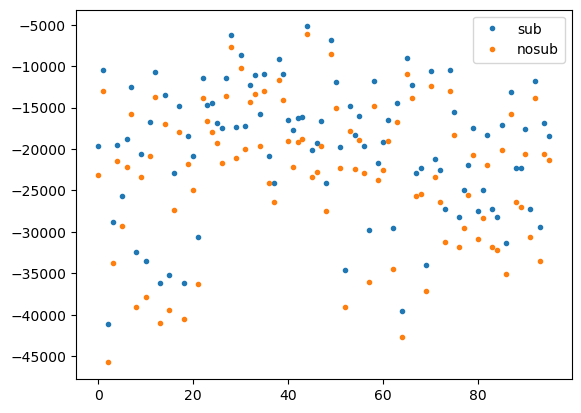

In [606]:
t = np.linspace(0,95,96)
fig,ax = plt.subplots()
#ax.plot(t,sub,marker='.',ls='')
ax.plot(t,arrT_sub,marker='.',ls='',label='sub')
ax.plot(t,arrT_nosub,marker='.',ls='',label='nosub')
ax.legend();

In [ ]:
'''
TODO
 - reconstruct unsubtracted disconnected piece from bubble data
     + how the product work 
     + can I get data in terms of t_sep from data in terms of t_src???

 - Do I need a t_src index in the average data? 


try to reconstruct the unsubtracted disconnected piece from the singular bubble data to make sure it is consistent after spatial sums. 
